In [75]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [615]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [623]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd

from sklearn.decomposition import FactorAnalysis
from matplotlib import collections as mc
import scipy
from sklearn.decomposition import PCA
from ProbabilisticPCA import PPCA

In [140]:
def plot_gaussian_contour(
    resolution,    # play with this parameter and you'll figure out
    xlim,          # xlim for which probability density is calculated. do not confuse with xlim of plot.
    ylim,          # ylim for which probability density is calculated. do not confuse with xlim of plot.
    means,         # mean vector for the multivariate gaussian
    cov,           # covariant matrix for the multivariate gaussian
    levels=5,      # 'levels' parameter for ax.contour(). Check their documentation for more detail.
    linewidths=1.2,# the linewidth of contour lines
    ax=None        # which ax to plot on
):
    # compute cartesian product of coordinates
    x = np.linspace(xlim[0], xlim[1], resolution)
    y = np.linspace(ylim[0], ylim[1], resolution)
    xx, yy = np.meshgrid(x, y)
    coordinates = np.dstack((xx, yy))
    # compute gaussian pdf for points in coordinates
    rv = multivariate_normal(means, cov)
    density = rv.pdf(coordinates)
    
    if ax is None:
        ax = plt.gca()
    ax.contour(xx, yy, density, colors='k', levels=levels, linewidths=linewidths)
    ax.set_aspect('equal')
    
    return ax

In [141]:
np.random.seed(102)
X = np.vstack(
    (
        np.random.multivariate_normal(mean=[1, 2], cov=[[1,0.2],[0.2,2]], size=70),
        np.random.multivariate_normal(mean=[5, 4], cov=[[1,0.2],[0.2,3]], size=70)
    )
)

# Factor Analysis

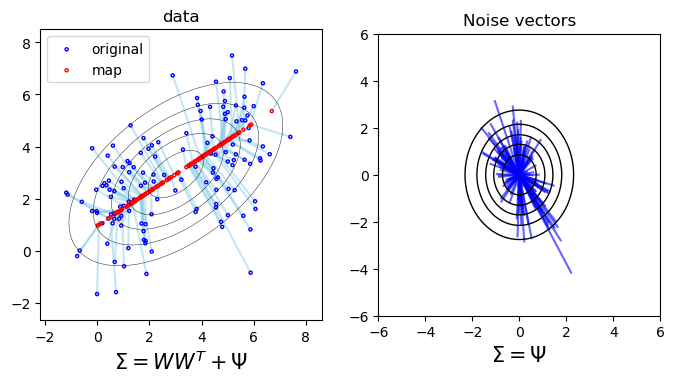

In [405]:
xlim = (X[:,0].min() - 1, X[:,0].max() + 1)
ylim = (X[:,1].min() - 1, X[:,1].max() + 1)

model = FactorAnalysis(n_components=1)
model.fit(X)
z = model.transform(X)
mapped = z * model.components_[0] + model.mean_

lines = [[(i[0], i[1]), (j[0], j[1])] for i, j in zip(mapped, X)]
lc = mc.LineCollection(lines, colors='skyblue', alpha=0.5, zorder=-100)


fig, axs = plt.subplots(1,2, figsize=(8,8), dpi=100)
axs[0].add_collection(lc)
axs[0].set_aspect('equal')
axs[0].set_title('data')

plot_gaussian_contour(
    resolution=200,
    xlim=xlim,
    ylim=ylim,
    means=model.mean_,
    cov=model.get_covariance(),
    levels=5,
    linewidths=0.3,
    ax=axs[0]
)

axs[0].scatter(X[:, 0], X[:, 1], facecolor='none', edgecolor='b', s=5, label='original')
axs[0].scatter(mapped[:, 0], mapped[:, 1], facecolor='none', edgecolor='r', s=5, label='map')
axs[0].legend()

plt_range = 6
lines = [[(0, 0), (j[0] - i[0], j[1] - i[1])] for i, j in zip(mapped, X)]
lc = mc.LineCollection(lines, colors='blue', alpha=0.6)
axs[1].add_collection(lc)
axs[1].set_xlim((-plt_range,plt_range))
axs[1].set_ylim((-plt_range,plt_range))
axs[1].set_title('Noise vectors')
plot_gaussian_contour(
    resolution=200,
    xlim=(-plt_range, plt_range),
    ylim=(-plt_range, plt_range),
    means=[0, 0],
    cov=np.diag(model.noise_variance_),
    levels=5,
    linewidths=1,
    ax=axs[1]
)

axs[0].set_xlabel(r"$\Sigma=WW^T+\Psi$", fontsize=15)
axs[1].set_xlabel("$\Sigma=\Psi$", fontsize=15)

print()
plt.savefig("Factor_analysis_data_and_noise.png")

In [357]:
model.noise_variance_

array([1.49879581, 2.13029447])

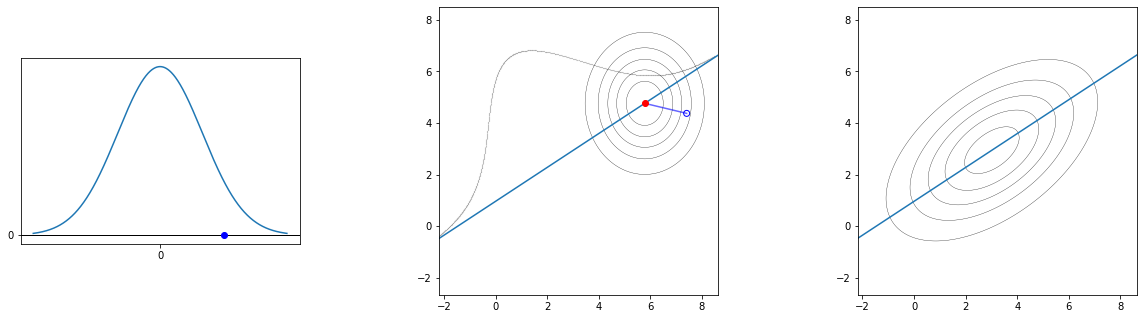

In [402]:
fig, axs = plt.subplots(1, 3, figsize=(20,10), gridspec_kw={"wspace": 0.5})

x = np.linspace(-3, 3, 1000)
pdf = scipy.stats.norm.pdf(x, 0, 1)

idx_sample = 750
sample_x = x[idx_sample]
sample_pdf = pdf[idx_sample]

# ax[0]
axs[0].scatter(sample_x, 0, c="b", zorder=10)
axs[0].plot(x, pdf)
axs[0].set_xticks([0])
axs[0].set_yticks([0])
# axs[0].set_xlabel("$z\sim N(0,1)$")
axs[0].set_aspect(10)
# axs[0].set_title("$P(z)$")
axs[0].axhline(0, linewidth=1, color='black', zorder=-1)

# ax[1]
slope = model.components_[0][1] / model.components_[0][0]

mapped_sample = sample_x * model.components_[0] + model.mean_
axs[1].scatter(mapped_sample[0], mapped_sample[1], color="red", zorder=10)
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].set_aspect("equal")

left_endpoint = -10 * model.components_[0] + model.mean_
right_endpoint = 10 * model.components_[0] + model.mean_
axs[1].plot([left_endpoint[0], right_endpoint[0]], [left_endpoint[1], right_endpoint[1]])

plot_gaussian_contour(
    resolution=200,
    xlim=xlim,
    ylim=ylim,
    means=mapped_sample,
    # cov=[[model.noise_variance_[0], 0], [0, model.noise_variance_[1]]],
    cov=np.diag(model.noise_variance_),
    levels=5,
    linewidths=0.3,
    ax=axs[1]
)

orth_vector = np.array((model.components_[0][1] * -1, model.components_[0][0]))
transformed_pdf = []
for x_, pdf_ in zip(x, pdf):
    mapped_point = x_ * model.components_ + model.mean_
    mapped_pdf = (mapped_point + (orth_vector * pdf_ * 5)).reshape(-1)
    transformed_pdf.append( mapped_pdf )
transformed_pdf = np.array(transformed_pdf)

axs[1].scatter(transformed_pdf[:, 0], transformed_pdf[:, 1], s=0.01, color="gray")
# axs[1].set_title("$P(x|z)$")

# axs[2]
#left_endpoint = -10 * model.components_[0] + model.mean_
#right_endpoint = 10 * model.components_[0] + model.mean_
axs[2].plot([left_endpoint[0], right_endpoint[0]], [left_endpoint[1], right_endpoint[1]])
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)
# axs[2].set_aspect("equal")
# axs[2].set_title("$P(x)$")

plot_gaussian_contour(
    resolution=200,
    xlim=xlim,
    ylim=ylim,
    means=model.mean_,
    # cov=np.matmul(model.components_[0].reshape(-1,1), model.components_[0].reshape(-1,1).T) + np.array([[model.noise_variance_[0], 0], [0, model.noise_variance_[1]]]),
    # cov=np.matmul(model.components_[0].reshape(-1,1), model.components_[0].reshape(-1,1).T) + np.diag([model.noise_variance_[0], model.noise_variance_[1]]),
    cov=model.get_covariance(),
    levels=5,
    linewidths=0.3,
    ax=axs[2]
)

x_noise_added = X[90]
axs[1].scatter(x_noise_added[0], x_noise_added[1], edgecolor='b', facecolor='none')
axs[1].plot([x_noise_added[0], mapped_sample[0]], [x_noise_added[1], mapped_sample[1]], color='b', alpha=0.6)
print()

plt.savefig("FactorAnalysis_latent_to_data.png")


In [376]:
model.get_covariance()

array([[4.88000651, 2.22087014],
       [2.22087014, 3.58902172]])

In [372]:
model.components_

array([[1.83880687, 1.20777782]])

In [379]:
cov = model.get_covariance()
model.get_covariance()[0][1] / np.sqrt(cov[0,0] * cov[1,1])

0.5306704708520182

In [265]:
orth_vector = np.array((model.components_[0][1] * -1, model.components_[0][0]))

In [305]:
transformed_pdf = []
for x_, pdf_ in zip(x, pdf):
    # transformed_pdf.append(x_ * orth_vector + line_)
    mapped_point = x_ * model.components_ + model.mean_
    mapped_pdf = (mapped_point + (orth_vector * pdf_ * 5)).reshape(-1)
    # print(mapped_pdf.shape)
    transformed_pdf.append( mapped_pdf )
transformed_pdf = np.array(transformed_pdf)
# transformed_pdf[:, 0] = x

In [138]:
# the longest line across the ovals does not perfectly aling with red points, because WW.T gets affect by noise covariance

# Probabilistic PCA

[6.59478516]
[6.59478516]
[6.59478516]
[6.59478516]


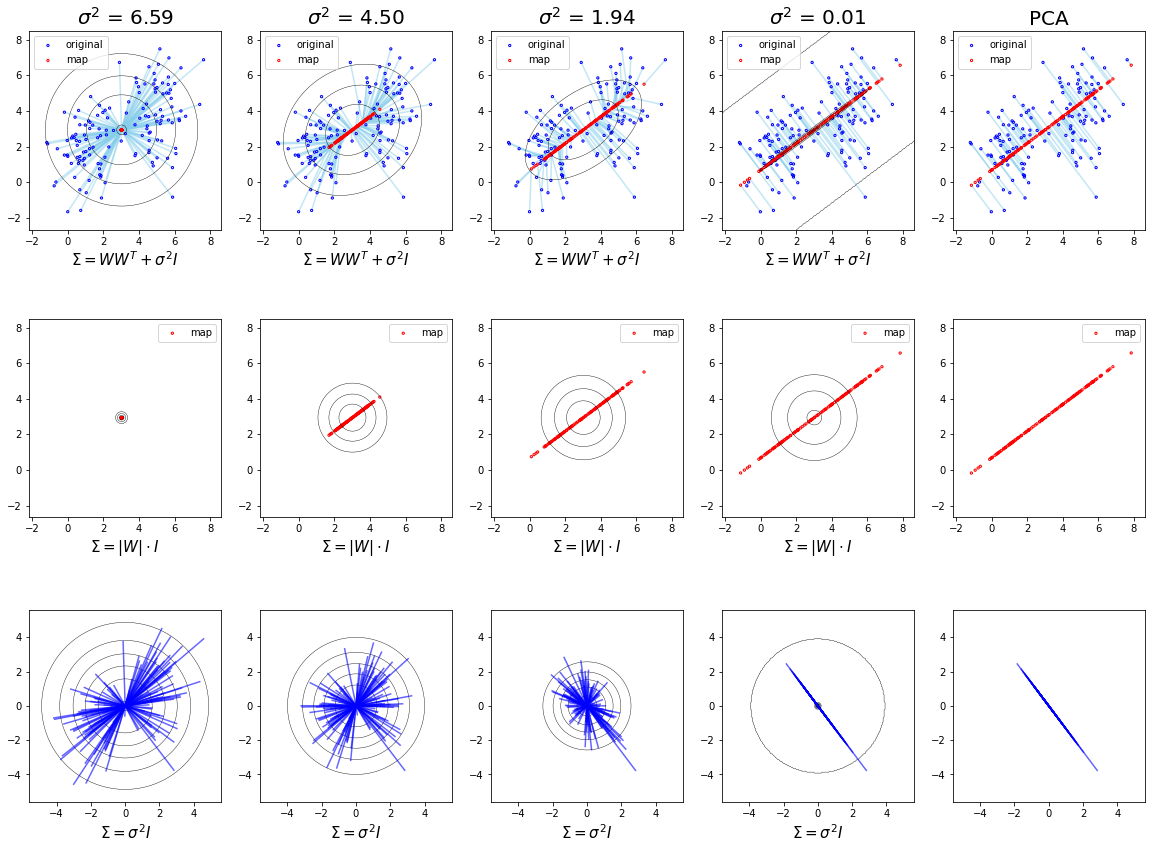

In [650]:
fig, axs = plt.subplots(3,5, figsize=(20, 15))
xlim = (X[:,0].min() - 1, X[:,0].max() + 1)
ylim = (X[:,1].min() - 1, X[:,1].max() + 1)

X_ = X - X.mean(axis=0)
max_dist = max(abs(X_[:, 0].min()), X_[:, 0].max(), abs(X_[:, 1].min()), X_[:, 1].max()) + 1

# for i, sigma in enumerate([1000, 30, None, 0.05]):
# for i, sigma in enumerate([None]):
for i, sigma in enumerate([6.593, 4.5, None, 0.01]):
    model = PPCA(n_components=1, sigma=sigma)
    model.fit(X)
    model.plot_data_gaussian_contour(   ax=axs[0, i], xlim=xlim, ylim=ylim, levels=3, linewidths=0.4)
    model.plot_latent_gaussian_contour( ax=axs[1, i], xlim=xlim, ylim=ylim, levels=3, linewidths=0.4)
    model.plot_noise_gaussian_contour(  ax=axs[2, i], xlim=(-max_dist, max_dist), ylim=(-max_dist, max_dist), levels=5, linewidths=0.4)
    
    Z = model.transform(X)
    mapped = Z * model.components_.T + X.mean(axis=0)
    lines = [[(m[0], m[1]), (x[0], x[1])] for m, x in zip(mapped, X)]
    lc = mc.LineCollection(lines, colors='skyblue', alpha=0.5, zorder=-100)

    axs[0, i].add_collection(lc)
    axs[0, i].set_xlabel("$\Sigma=WW^T+\sigma^2I$", fontsize=15)
    axs[0, i].scatter(X[:, 0], X[:, 1], facecolor='none', edgecolor='b', s=5, label='original')
    axs[0, i].scatter(mapped[:, 0], mapped[:, 1], facecolor='none', edgecolor='r', s=5, label='map')
    axs[0, i].set_title("$\sigma^2$ = {:.2f}".format(model.sigma_), fontsize=20)

    axs[1, i].scatter(mapped[:, 0], mapped[:, 1], facecolor='none', edgecolor='r', s=5, label='map')
    axs[1, i].set_xlabel("$\Sigma=|W|\cdot I$", fontsize=15)
    
    lines = [[(0, 0), (j[0] - i[0], j[1] - i[1])] for i, j in zip(mapped, X)]
    lc = mc.LineCollection(lines, colors='blue', alpha=0.6)
    axs[2, i].add_collection(lc)
    axs[2, i].set_xlabel("$\Sigma=\sigma^2I$", fontsize=15)

# PCA upper row
model = PCA(n_components=1)
X_ = X - X.mean(axis=0)
Z = model.fit_transform(X_)
mapped = Z * model.components_[0] + X.mean(axis=0)


lines = [[(m[0], m[1]), (x[0], x[1])] for m, x in zip(mapped, X)]
lc = mc.LineCollection(lines, colors='skyblue', alpha=0.5, zorder=-100)

axs[0, 4].add_collection(lc)
axs[0, 4].scatter(X[:, 0], X[:, 1], facecolor='none', edgecolor='b', s=5, label='original')
axs[0, 4].scatter(mapped[:, 0], mapped[:, 1], facecolor='none', edgecolor='r', s=5, label='map')
axs[0, 4].set_title("PCA", fontsize=20)
# PCA middle row
axs[1, 4].scatter(mapped[:, 0], mapped[:, 1], facecolor='none', edgecolor='r', s=5, label='map')
# PCA bottom row
lines = [[(0, 0), (j[0] - i[0], j[1] - i[1])] for i, j in zip(mapped, X)]
lc = mc.LineCollection(lines, colors='blue', alpha=0.6)
axs[2, 4].add_collection(lc)

for ax in axs.ravel()[:10]:
    ax.set_aspect('equal')
    ax.legend()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

for ax in axs.ravel()[10:]:
    ax.set_aspect('equal')
    ax.set_xlim((-max_dist, max_dist))
    ax.set_ylim((-max_dist, max_dist))
plt.savefig("PPCA.png")

# MNIST dataset

In [407]:
df_train = pd.read_csv("mnist_train.csv")
df_test = pd.read_csv("mnist_test.csv")
# df_train = df_train[df_train['label']==3]
Xtrain = np.array(df_train.drop(labels="label", axis=1))
Ytrain = np.array(df_train["label"])

Reconstruction of MNIST dataset using different numbers of principal components:


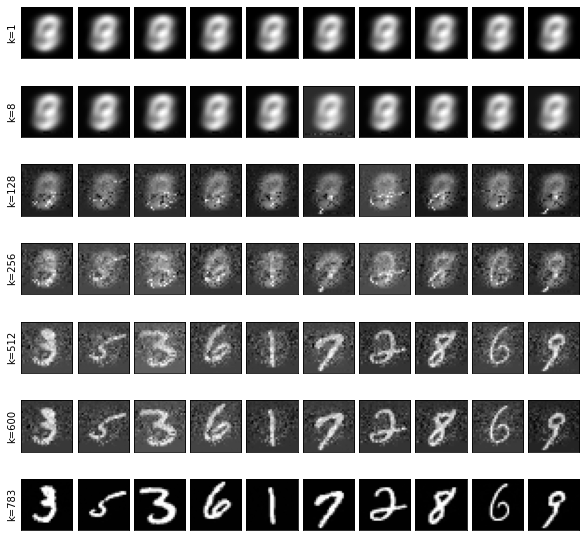

In [432]:
# code credit: Dr. Peter Sadowski
mnist_mu = Xtrain.mean(axis=0).reshape(1, -1)
Xtrain_ = Xtrain - mnist_mu


# k_values = [1, 2, 4, 8, 16, 32, 64, 128, 512, 783]
k_values = [1, 8, 128, 256, 512, 600, 783]
# k_values = [512, 780]
fig, ax = plt.subplots(len(k_values), 10, figsize=(10, 10),
                       subplot_kw={'xticks': [], 'yticks': []},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1)
                      )
print('Reconstruction of MNIST dataset using different numbers of principal components:')
for j, k in enumerate(k_values):
    model = PPCA(n_components=k)
    model.fit(Xtrain_)
    W = model.components_
    M = W.T.dot(W) + model.sigma_ * np.identity(k)
    Z = model.transform(Xtrain_[10:20, :])

    for i in range(10):
        # reconstruction = W.dot(np.linalg.inv(W.T.dot(W))).dot(M).dot(Z[i]).reshape(-1,1) + mnist_mu.reshape(-1,1)
        reconstruction = model.components_.dot(Z[i].reshape(k, -1)) + mnist_mu.reshape(-1, 1)
#         print(model.components_.shape)
#         print(Z[i].shape)
#         print(mnist_mu.shape)
        
#         print(model.components_.dot(Z[i].reshape(k, -1)).shape)
        # Z * model.components_[0] + X.mean(axis=0)
        ax[j, i].imshow(reconstruction.reshape(28, 28), cmap='gray')
    ax[j, 0].set_ylabel(f"k={k}")
plt.savefig('PPCA_table.png')

Reconstruction of MNIST dataset using different numbers of principal components:
(10, 1) (1, 784)
(10, 8) (8, 784)
(10, 128) (128, 784)
(10, 256) (256, 784)
(10, 512) (512, 784)
(10, 600) (600, 784)
(10, 784) (784, 784)


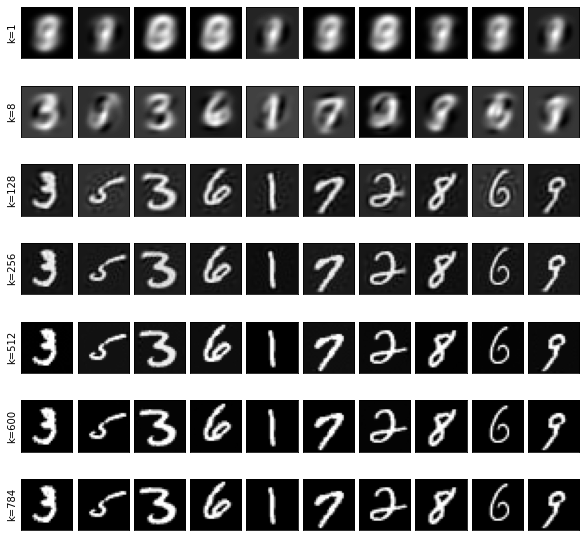

In [512]:
# code credit: Dr. Peter Sadowski
mnist_mu = Xtrain.mean(axis=0).reshape(1, -1)
Xtrain_ = Xtrain - mnist_mu


# k_values = [1, 2, 4, 8, 16, 32, 64, 128, 512, 783]
k_values = [1, 8, 128, 256, 512, 600, 784]
# k_values = [512, 780]
fig, ax = plt.subplots(len(k_values), 10, figsize=(10, 10),
                       subplot_kw={'xticks': [], 'yticks': []},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1)
                      )
print('Reconstruction of MNIST dataset using different numbers of principal components:')
for j, k in enumerate(k_values):
    model = PCA(n_components=k)
    model.fit(Xtrain_)
    # W = model.components_
    # M = W.T.dot(W) + model.sigma_ * np.identity(k)
    Z = model.transform(Xtrain_[10:20, :])
    print(Z.shape, model.components_.shape)

    for i in range(10):
        # reconstruction = W.dot(np.linalg.inv(W.T.dot(W))).dot(M).dot(Z[i]).reshape(-1,1) + mnist_mu.reshape(-1,1)
        reconstruction = model.components_.T.dot(Z[i].reshape(k, -1)) + mnist_mu.reshape(-1, 1)
#         print(model.components_.shape)
#         print(Z[i].shape)
#         print(mnist_mu.shape)
        
#         print(model.components_.dot(Z[i].reshape(k, -1)).shape)
        # Z * model.components_[0] + X.mean(axis=0)
        ax[j, i].imshow(reconstruction.reshape(28, 28), cmap='gray')
    ax[j, 0].set_ylabel(f"k={k}")
plt.savefig('PCA_table.png')

# Synthesize new data

In [653]:
Xtrain_5 = np.array(df_train[df_train['label']==5].drop(labels='label', axis=1))
mu_5 = np.mean(Xtrain_5, axis=0)
n_components = 783
model = PPCA(n_components = n_components)
model.fit(Xtrain_5 - mu_5)

[]

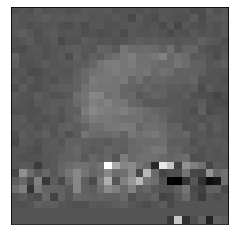

In [654]:
W = model.components_
sample = np.random.multivariate_normal(mu_5, W.dot(W.T) + model.sigma_ * np.identity(784))
# sample = np.random.multivariate_normal(mu_5, model.sigma_ * np.identity(784))
fig, ax = plt.subplots(1)
ax.imshow(sample.reshape(28, 28), cmap='gray')
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

In [568]:
# this part is contained in the below table plot
# W = model.components_
# # sample = np.random.multivariate_normal(mu_5, W.dot(W.T) + model.sigma_ * np.identity(784))
# sample_z = np.random.multivariate_normal(model.transform(Xtrain_5[0].reshape(1, -1)).reshape(-1), model.sigma_ * np.identity(n_components))
# sample_x = model.components_.dot(sample_z.reshape(n_components, -1)) + mu_5.reshape(-1, 1)
# fig, ax = plt.subplots(1)
# ax.imshow(sample_x.reshape(28, 28), cmap='gray')
# ax.set_aspect('equal')
# ax.set_xticks([])
# ax.set_yticks([])

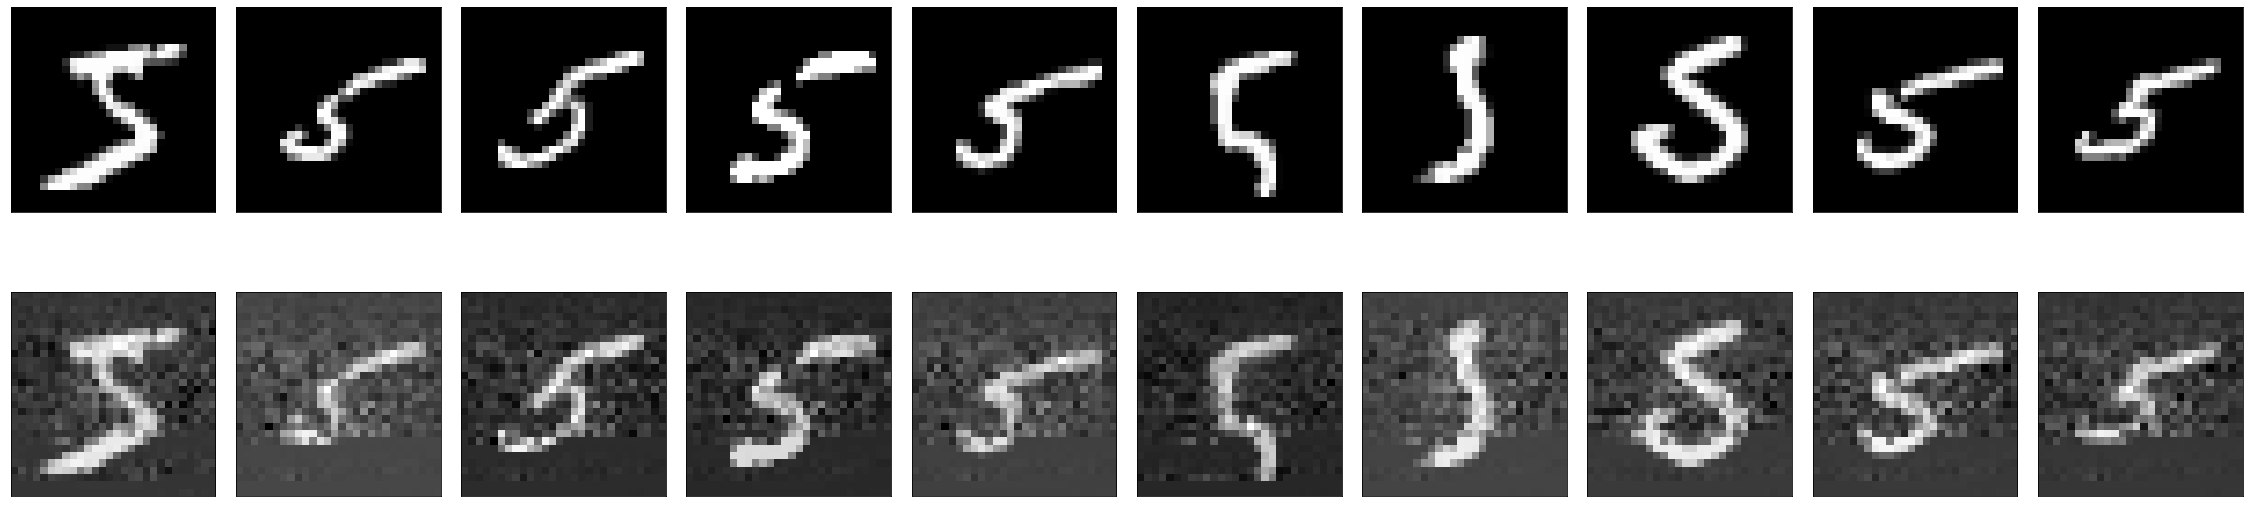

In [594]:
n_components = 600
model = PPCA(n_components = n_components)
model.fit(Xtrain_5 - Xtrain_5.mean(axis=0))

W = model.components_
M = W.T.dot(W) + model.sigma_ * np.identity(n_components)

fig, axs = plt.subplots(
    2, 10, 
    subplot_kw={'aspect':'equal', "xticks": [], "yticks": []},
    gridspec_kw=dict(hspace=0.1, wspace=0.1),
    figsize=(40,10)
)

for i in range(10):
    axs[0, i].imshow(Xtrain_5[i].reshape(28, 28), cmap='gray')
    
for i in range(10):
    mu = np.linalg.inv(M).dot(W.T).dot(Xtrain_5[i] - mu_5)
    cov = model.sigma_ * np.linalg.inv(M)
    # sample from posterior
    sample_z = np.random.multivariate_normal(mu, cov, size=1)

    sample_x = model.components_.dot(sample_z.reshape(n_components, -1)) + mu_5.reshape(-1, 1)
    axs[1, i].imshow(sample_x.reshape(28, 28), cmap='gray')
    axs[1, i].set_aspect('equal')
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

In [590]:
mu_5.shape, mnist_mu.shape

((784,), (1, 784))

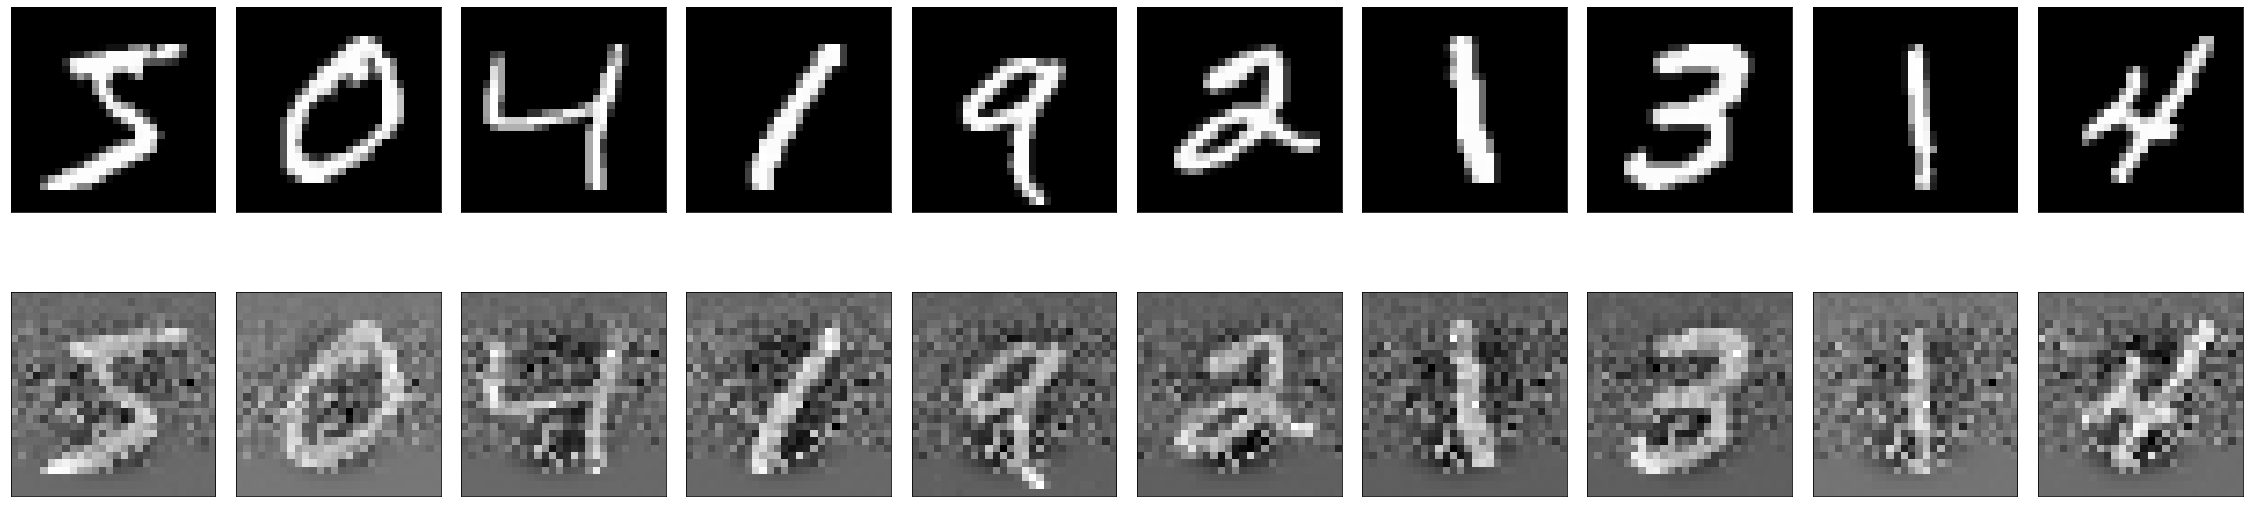

In [592]:
n_components = 600
model = PPCA(n_components = n_components)
model.fit(Xtrain_)

W = model.components_
M = W.T.dot(W) + model.sigma_ * np.identity(n_components)

fig, axs = plt.subplots(
    2, 10, 
    subplot_kw={'aspect':'equal', "xticks": [], "yticks": []},
    gridspec_kw=dict(hspace=0.1, wspace=0.1),
    figsize=(40,10)
)

for i in range(10):
    axs[0, i].imshow((Xtrain_[i] + mnist_mu).reshape(28, 28), cmap='gray')
    
for i in range(10):
    mu = np.linalg.inv(M).dot(W.T).dot(Xtrain_[i] - mnist_mu.reshape(-1))
    cov = model.sigma_ * np.linalg.inv(M)
    # sample from posterior
    sample_z = np.random.multivariate_normal(mu, cov, size=1)

    sample_x = model.components_.dot(sample_z.reshape(n_components, -1)) + mnist_mu.reshape(-1, 1)
    axs[1, i].imshow(sample_x.reshape(28, 28), cmap='gray')
    axs[1, i].set_aspect('equal')
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

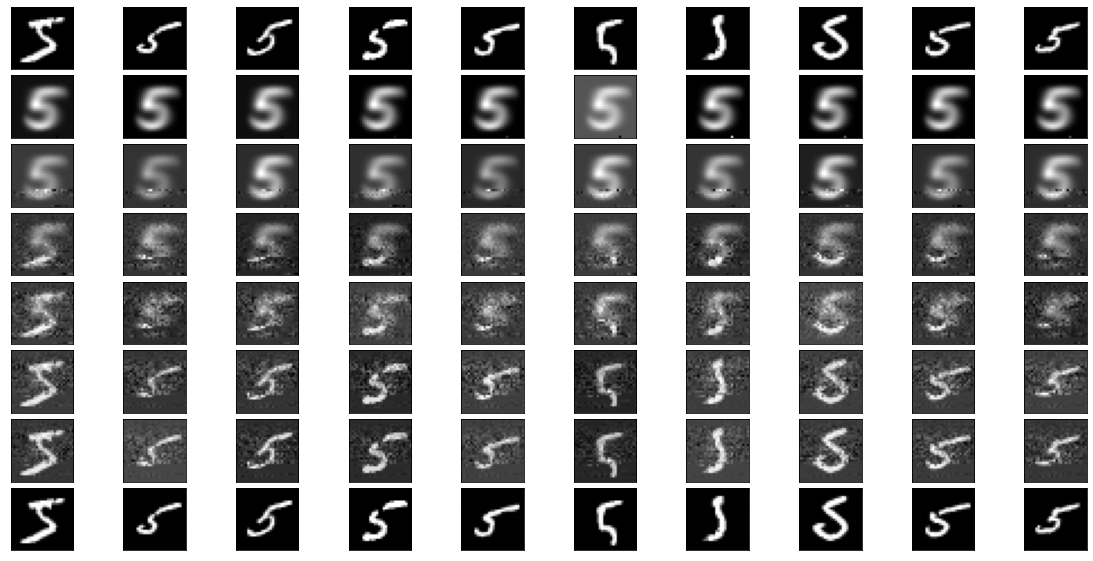

In [582]:
k_values = [1, 8, 128, 256, 512, 600, 783]
fig, axs = plt.subplots(
    len(k_values) + 1, 10,
    subplot_kw={'aspect':'equal', "xticks": [], "yticks": []},
    gridspec_kw=dict(hspace=0.1, wspace=0.1),
    figsize=(20,10)
)

for i in range(10):
    axs[0, i].imshow(Xtrain_5[i].reshape(28, 28), cmap='gray')
for i, k in enumerate(k_values):
    model = PPCA(n_components = k)
    model.fit(Xtrain_5)
    
    W = model.components_
    M = W.T.dot(W) + model.sigma_ * np.identity(k)
    
    for j in range(10):
        mu = np.linalg.inv(M).dot(W.T).dot(Xtrain_5[j] - mu_5)
        cov = model.sigma_ * np.linalg.inv(M)
        # sample from posterior
        sample_z = np.random.multivariate_normal(mu, cov, size=1)

        sample_x = model.components_.dot(sample_z.reshape(k, -1)) + mu_5.reshape(-1, 1)
        axs[i+1, j].imshow(sample_x.reshape(28, 28), cmap='gray')
        axs[i+1, j].set_aspect('equal')
        axs[i+1, j].set_xticks([])
        axs[i+1, j].set_yticks([])

In [ ]:
sample = np.random.multivariate_normal((Xtrain[0]))

[]

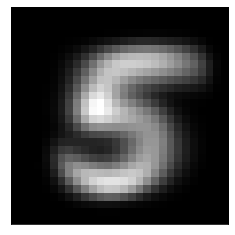

In [385]:
# Calculate the mean of 3 and sample from the posterior
sample = mu_5
m = np.linalg.inv(M).dot(W.T).dot((sample - mnist_mu).reshape(-1, 1))
cov = np.linalg.inv(M) * model.sigma_
# sample from posterior
z = np.random.multivariate_normal(m.reshape(-1), cov)
# z = np.random.multivariate_normal(np.zeros(783), np.identity(783))
# z = np.zeros(783)
reconstruction = W.dot(np.linalg.inv(W.T.dot(W))).dot(M).dot(z).reshape(-1,1) + mnist_mu.reshape(-1,1)
fig, ax = plt.subplots(1)
ax.imshow(reconstruction.reshape(28, 28), cmap='gray')
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

Text(0.5, 1.0, 'Original data')

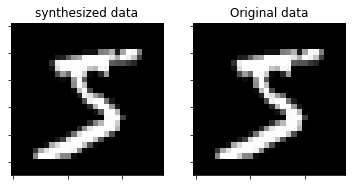

In [399]:
# choose a sample and sample from the posterior
sample = Xtrain[0]
m = np.linalg.inv(M).dot(W.T).dot((sample - mnist_mu).reshape(-1, 1))
cov = np.linalg.inv(M) * model.sigma_
# sample from posterior
z = np.random.multivariate_normal(m.reshape(-1), cov)
# z = np.random.multivariate_normal(np.zeros(783), np.identity(783))
# z = np.zeros(783)

reconstruction = W.dot(np.linalg.inv(W.T.dot(W))).dot(M).dot(z).reshape(-1,1) + mnist_mu.reshape(-1,1)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(reconstruction.reshape(28, 28), cmap='gray')
axs[0].set_aspect('equal')
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[0].set_title("synthesized data")

axs[1].imshow(Xtrain[0].reshape(28, 28), cmap='gray')
axs[1].set_aspect('equal')
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
axs[1].set_title("Original data")

[]

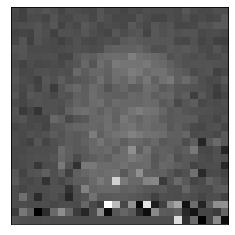

In [391]:
# simply sample from the prior
sample = Xtrain[0]
m = np.linalg.inv(M).dot(W.T).dot((sample - mnist_mu).reshape(-1, 1))
cov = np.linalg.inv(M) * model.sigma_
# sample from posterior
#z = np.random.multivariate_normal(m.reshape(-1), cov)
z = np.random.multivariate_normal(np.zeros(783), np.identity(783))
# z = np.zeros(783)

reconstruction = W.dot(np.linalg.inv(W.T.dot(W))).dot(M).dot(z).reshape(-1,1) + mnist_mu.reshape(-1,1)
fig, ax = plt.subplots(1)
ax.imshow(reconstruction.reshape(28, 28), cmap='gray')
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])